# Segment and Measure

**Goal:** Demonstrate how to call ImageJ1-style segmentation and measurement macros from Python, and consume the results on the Python side.

In [1]:
import imagej
ij = imagej.init('net.imagej:imagej:2.1.0')

Open the image _on the ImageJ side_ so that ImageJ1 knows about it.

Unfortunately, we cannot use `ij.io().open(...)` because ImageJ1 won't know about the image when running headless—_even if we convert it_ to an `ImagePlus` afterward. This is a limitation of the fact that ImageJ1 keeps track of images via their `ImageWindow`s, which extend `java.awt.Frame` and thus cannot exist headless.

In [ ]:
ij.py.run_macro("""

""")

In [2]:
macro = """
#@ Integer(label="Median filter radius", min=0, value=5) medianRadius
#@ String(label="Threshold method", choices={"Otsu", "Moments", "Triangle"}) thresholdMethod
#@ Integer(label="Number of erosions", value=0) numErosions
#@ Integer(label="Number of dilations", value=0) numDilations
#@ Boolean(label="Watershed") watershed
#@ String(label="Particle size range", value="0-Infinity") pSizeRange
#@ String(label="Particle circularity range", value="0.0-1.0") pCircularityRange

setBatchMode(true);

image = getImageID();

// Work on an 8-bit copy of the image.
// HACK: Avoid duplicate bringing in multiple channels.
Stack.setDisplayMode("grayscale");
run("Duplicate...", " ");
imageSlice = getImageID();
run("8-bit");

// Median filter.
if (medianRadius > 0) {
	run("Median...", "radius=" + medianRadius);
}

// Threshold.
setAutoThreshold(thresholdMethod + " dark");

// Mask preprocessing.
run("Create Mask");
mask = getImageID();
setOption("BlackBackground", true);
for (i=0; i<numErosions; i++) {
	run("Erode");
}
for (i=0; i<numDilations; i++) {
	run("Dilate");
}
if (watershed) {
	run("Watershed");
}

// Split mask into particles.
run("Set Measurements...", "area mean standard min centroid center median redirect=None decimal=3");
run("Analyze Particles...", "exclude add");
selectWindow("confocal-series.tif");
run("ROI Manager...");
selectWindow("mask");
run("Analyze Particles...", "size=" + pSizeRange + " circularity=" + pCircularityRange + " exclude add");

// Close temporary images.
selectImage(mask);
close();
selectImage(imageSlice);
close();
selectImage(image);

// Measure.
roiManager("Show None");
roiManager("Show All");
roiManager("Measure");
"""

[java.lang.Enum.toString] [INFO] Populating metadata


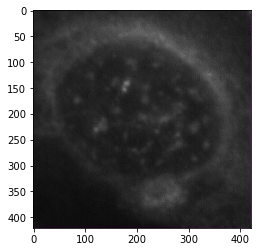

In [5]:
nucleus = ij.io().open('https://imagej.net/images/Fibroblast_Cell_Nucleus.jpg')
ij.py.show(nucleus)

In [24]:
ImagePlus = jimport('ij.ImagePlus')
imp = ij.convert().convert(nucleus, ImagePlus.class_)
imp

<java object 'ij.CompositeImage'>

In [4]:
args = {
    'medianRadius': 5,
    'thresholdMethod': 'Otsu',
    'numErosions': 3,
    'numDilations': 0,
    'watershed': True,
    'pSizeRange': '0-Infinity',
    'pCircularityRange': '0.5-1.0'
}
ij.py.run_macro(macro, args)

[java.lang.Enum.toString] Macro Error: There are no images open in line 12
 
image = getImageID ( <)> ; [java.lang.Enum.toString] 


<java object 'org.scijava.script.ScriptModule'>

In [37]:
macro = """
#@ ImagePlus imp
selectImage(imp);
run("Duplicate...", " ");
working = getImageID();
run("Duplicate...", " ");
run("Gaussian Blur...", "sigma=50");
blurred = getImageID();
imageCalculator("Subtract create 32-bit", working, blurred);
corrected = getImageID();
setAutoThreshold("Otsu dark");
run("Create Mask");
setOption("BlackBackground", true);
run("Erode");
run("Erode");
run("Create Selection");
run("Convex Hull");
run("Fit Ellipse");
run("Enlarge...", "enlarge=-50");
selectImage(working);
run("Restore Selection");
selectImage(corrected);
close();
selectImage(blurred);
close();
selectImage(working);
run("Find Maxima...", "prominence=10 output=[Point Selection]");
run("Set Measurements...", "  redirect=None decimal=3");
run("Measure");
"""

In [38]:
#WindowManager = jimport('ij.WindowManager')
#WindowManager.setTempCurrentImage(imp)
#WindowManager.addImage(imp);
ij.py.run_macro(macro, args = {'imp': imp})

[java.lang.Enum.toString] Macro Error: Image -3 not found in line 3
 
selectImage ( <imp> ) ; [java.lang.Enum.toString] 


<java object 'org.scijava.script.ScriptModule'>

In [7]:
from scyjava import jimport
ResultsTable = jimport('ij.measure.ResultsTable')
rt = ResultsTable.getResultsTable()
rt

<java object 'ij.measure.ResultsTable'>

In [10]:
Table = jimport('org.scijava.table.Table')
sjTable = ij.convert().convert(rt, Table.class_)
pandasTable = ij.py.from_java(sjTable)

In [15]:
pandasTable = scyjava._table_to_pandas(sjTable)